<h1>Import necessary libraries</h1>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math 
import operator

<h1>Function to calculate accuracy and to split a  dataset </h1>

In [3]:



def accuracy_score(y_true, y_pred):

    """	score = (y_true - y_pred) / len(y_true) """

    return round(float(sum(y_pred == y_true))/float(len(y_true)) * 100 ,2)

def train_test_split(x, y, test_size = 0.25, random_state = None):

    """ partioning the data into train and test sets """

    x_test = x.sample(frac = test_size, random_state = random_state)
    y_test = y[x_test.index]

    x_train = x.drop(x_test.index)
    y_train = y.drop(y_test.index)

    return x_train, x_test, y_train, y_test
eps = np.finfo(float).eps

<h1>Build decision tree </h1>

In [10]:
class C45tree:

    def __init__(self,cutoffs, max_depth = None, min_sample_leaf = None):

        self.depth = 0 #Depth of the tree
        self.max_depth = max_depth	#Maximum depth of the tree
        self.min_sample_leaf = min_sample_leaf	#Minimum number of samples for each node

        self.features = list
        self.X_train = np.array
        self.y_train = np.array
        self.num_feats = int 
        self.train_size = int 
        self.cutoffs =cutoffs
        self.entro =0  
        
    def fit(self, X, y):

        self.X_train = X 
        self.y_train = y
        self.features = list(X.columns)
        self.train_size = X.shape[0]
        self.num_feats = X.shape[1]

        df = X.copy()
        df['target'] = y.copy()

        #Builds Decision Tree
        self.tree = self._build_tree(df)

        #print("\nDecision Tree(depth = {}) : \n {}".format(self.depth, self.tree))
      
    def _build_tree(self, df, tree = None):

      

        #Get feature with maximum information gain
        feature, cutoff,entro = self._find_best_split(df)    
        entro=round(entro, 1)
        self.cutoff=cutoff    
        #Initialization of tree
        if tree is None:
            tree = {}
            tree[feature] = {}
            

        
            """
                - to handle columns with Numerical Values(int, float....)
                - parent have two child
                - Left Child: rows with <= cutoff
                - Right Child:  rows with > cutoff
            """
        #Left Child
        new_df = self._split_rows(df, feature, cutoff, operator.le)
        targets, count = np.unique(new_df['target'], return_counts = True)


        self.depth += 1

        if(len(count) == 1): #pure group
            tree[feature]['<=' + str(cutoff)] = targets[0]
        else:

                #Prepruning tree

            if entro <self.cutoffs:

                tree[feature]['<=' + str(cutoff)] = targets[np.argmax(count)]
            else:
                tree[feature]['<=' + str(cutoff)] = self._build_tree(new_df)


        #Right Child
        #print(entro)            
        new_df = self._split_rows(df, feature, cutoff, operator.gt)
        targets, count = np.unique(new_df['target'], return_counts = True)

        if(len(count) == 1): #pure group
            tree[feature]['>' + str(cutoff)] = targets[0]
        else:
            #if self.max_depth is not None and self.depth >= self.max_depth:
            if  entro<self.cutoffs:

                tree[feature]['>' + str(cutoff)] = targets[np.argmax(count)]
            else:
                tree[feature]['>' + str(cutoff)] = self._build_tree(new_df)

        return tree
    
    
    def _split_rows(self, df, feature, feat_val, operation ):


        return df[operation(df[feature], feat_val)].reset_index(drop = True)
    
    
    def _find_best_split(self, df):

        

        ig = []
        thresholds = []
        entro = []        

        for feature in list(df.columns[:-1]):

            entropy_parent = self._get_entropy(df) #H(T)
            entropy_feature_split, threshold = self._get_entropy_feature(df, feature) #H(T|a)
            #print(entropy_feature_split)
            info_gain = entropy_parent - entropy_feature_split #IG(T, a)

            ig.append(info_gain)
            thresholds.append(threshold)
            entro.append(entropy_feature_split)


        return df.columns[:-1][np.argmax(ig)],thresholds[np.argmax(ig)],entro[np.argmax(ig)] #Returns feature with max information gain 

    def _get_entropy(self, df):

        #Finds Entropy of parent

        entropy = 0
        for target in np.unique(df['target']):
            fraction = df['target'].value_counts()[target] / len(df['target'])
            entropy += -fraction * np.log2(fraction)

        return entropy

    def _get_entropy_feature(self, df, feature):

       
        entropy = 0
        threshold = None

        if(df[feature].dtypes == object):

            #sum of entropies of children(all distinct features)
            for feat_val in np.unique(df[feature]):
                entropy_feature = 0

                #entropy for each distinct feature value
                for target in np.unique(df['target']):
                    num = len(df[feature][df[feature] == feat_val][df['target'] == target])
                    den = len(df[feature][df[feature] == feat_val])

                    fraction = num / (den+eps)
                    entropy_feature += -fraction * np.log2(fraction + eps)

                weightage = den/len(df)
                entropy += weightage * entropy_feature
        else:
            entropy = 1 #Max Value

            prev = 0
            for feat_val in np.unique(df[feature]):
                cur_entropy = 0
                cutoff = (feat_val + prev)/2

                #sum of entropies of left child(<= cutoff) and right child(> cutoff)
                for operation in [operator.le, operator.gt]:
                    entropy_feature = 0

                    for target in np.unique(df['target']):
                        num = len(df[feature][operation(df[feature], cutoff)][df['target'] == target])
                        den = len(df[feature][operation(df[feature], cutoff)])

                        fraction = num / (den + eps)
                        entropy_feature += -fraction * np.log2(fraction + eps)

                    weightage = den/len(df)
                    cur_entropy += weightage * entropy_feature

                if cur_entropy < entropy:
                    entropy = cur_entropy
                    threshold = cutoff
                prev = feat_val

        return entropy, threshold

    def _predict_target(self, feature_lookup, x, tree):

        for node in tree.keys():
            val = x[node]
            if type(val) == str:
                tree = tree[node][val]
            else:
                cutoff = str(list(tree[node].keys())[0]).split('<=')[1]

                if(val <= float(cutoff)):    #Left Child
                    tree = tree[node]['<='+cutoff]
                else:        #Right Child
                    tree = tree[node]['>'+cutoff]

            prediction = str

            if type(tree) is dict:
                prediction = self._predict_target(feature_lookup, x, tree)
            else:
                predicton = tree 
                return predicton

        return prediction   

    def predict(self, X):

        results = []
        feature_lookup = {key: i for i, key in enumerate(list(X.columns))}

        for index in range(len(X)):

            results.append(self._predict_target(feature_lookup, X.iloc[index], self.tree))

        return np.array(results)    


<h1> Preprocessing dataset </h1>

In [11]:
if __name__ == '__main__':



    data = pd.read_csv('adult.csv')

    data = data[data.workclass!='?']
    data = data[data.fnlwgt!='?']
    data = data[data.education!='?']

    data = data[data["marital.status"]!='?']
    data = data[data.occupation!='?']
    data = data[data.relationship!='?']
    data = data[data.race!='?']
    data = data[data.sex !='?']
    data = data[data["capital.gain"]!='?']
    data = data[data["capital.loss"]!='?']
    data = data[data["hours.per.week"]!='?']
    data['income'].replace({'<=50K':0,'>50K':1},inplace=True)
    from sklearn import preprocessing
    # label_encoder object knows how to understand word labels. 
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column 'Country'. 
    data['workclass']= label_encoder.fit_transform(data['workclass']) 
    data['marital.status']= label_encoder.fit_transform(data['marital.status']) 
    data['education']= label_encoder.fit_transform(data['education']) 
    data['occupation']= label_encoder.fit_transform(data['occupation']) 
    data['relationship']= label_encoder.fit_transform(data['relationship']) 
    data['race']= label_encoder.fit_transform(data['race']) 
    data['sex']= label_encoder.fit_transform(data['sex'])
    data['native.country']= label_encoder.fit_transform(data['native.country'])

    from sklearn.preprocessing import MinMaxScaler

    columns_to_scale = ['age', 'capital.gain', 'capital.loss', 'hours.per.week','fnlwgt']
    mms = MinMaxScaler()
    min_max_scaled_columns = mms.fit_transform(data[columns_to_scale])

    data['age'],data['capital.gain'],data['capital.loss'],data['hours.per.week'],data['fnlwgt']= min_max_scaled_columns[:,0],min_max_scaled_columns[:,1],min_max_scaled_columns[:,2],min_max_scaled_columns[:,3],min_max_scaled_columns[:,4]              

    print(data)
    #Split Features and target
    X, y = data.drop([data.columns[-1]], axis = 1), data[data.columns[-1]]

    #Split data into Training and Testing Sets
 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


            age  workclass    fnlwgt  education  education.num  \
1      0.890411          2  0.080970         11              9   
3      0.506849          2  0.086061          5              4   
4      0.328767          2  0.170568         15             10   
5      0.232877          2  0.138072         11              9   
6      0.287671          2  0.093024          0              6   
...         ...        ...       ...        ...            ...   
32556  0.068493          2  0.201493         15             10   
32557  0.136986          2  0.165563          7             12   
32558  0.315068          2  0.095589         11              9   
32559  0.561644          2  0.093914         11              9   
32560  0.068493          2  0.127620         11              9   

       marital.status  occupation  relationship  race  sex  capital.gain  \
1                   6           3             1     4    0           0.0   
3                   0           6             4     4  

<h1> Build model and check accuracy for different cutoff values</h1>

In [12]:
from sklearn.metrics import mean_squared_error

cutoff=[0.2,0.4,0.6,0.8]
trainac=[]
testac=[]
valac=[]
train_error=[]
tester=[]
valer=[]
for i in cutoff:
    dt_clf =  C45tree(cutoffs = i)
    dt_clf.fit(X_train, y_train)
    train_ac=format(accuracy_score(y_train, dt_clf.predict(X_train)))
    y_pred=dt_clf.predict(X_train)
    training_error = mean_squared_error(y_train,y_pred)
    train_error.append(training_error)
    
    
    test_ac=format(accuracy_score(y_test, dt_clf.predict(X_test)))
    y_pred1=dt_clf.predict(X_test)
    test_error = mean_squared_error(y_test,y_pred1)
    tester.append(test_error)
    
    
    val_ac=format(accuracy_score(y_val, dt_clf.predict(X_val)))
    y_pred2=dt_clf.predict(X_val)
    validation_error = mean_squared_error(y_val,y_pred2)
    valer.append(validation_error)
  
    trainac.append(train_ac)
    testac.append(test_ac)
    valac.append(val_ac)
  


<h1> Training,validation and test accuracy </h1>

In [13]:
all_accuracy = [[cutoff[0],trainac[0],testac[0],valac[0]],[cutoff[1],trainac[1],testac[1],valac[1]],[cutoff[2],trainac[2],testac[2],valac[2]],[cutoff[3],trainac[3],testac[3],valac[3]] ]

accuracy_summary = pd.DataFrame(data = all_accuracy, columns=['Cut off','Training accuracy','test accuracy','validation accuracy'])
accuracy_summary 

,Cut off,Training accuracy,test accuracy,validation accuracy
0,0.2,99.19,81.56,81.08
1,0.4,96.02,83.22,82.38
2,0.6,92.22,83.17,83.01
3,0.8,75.13,75.23,74.79


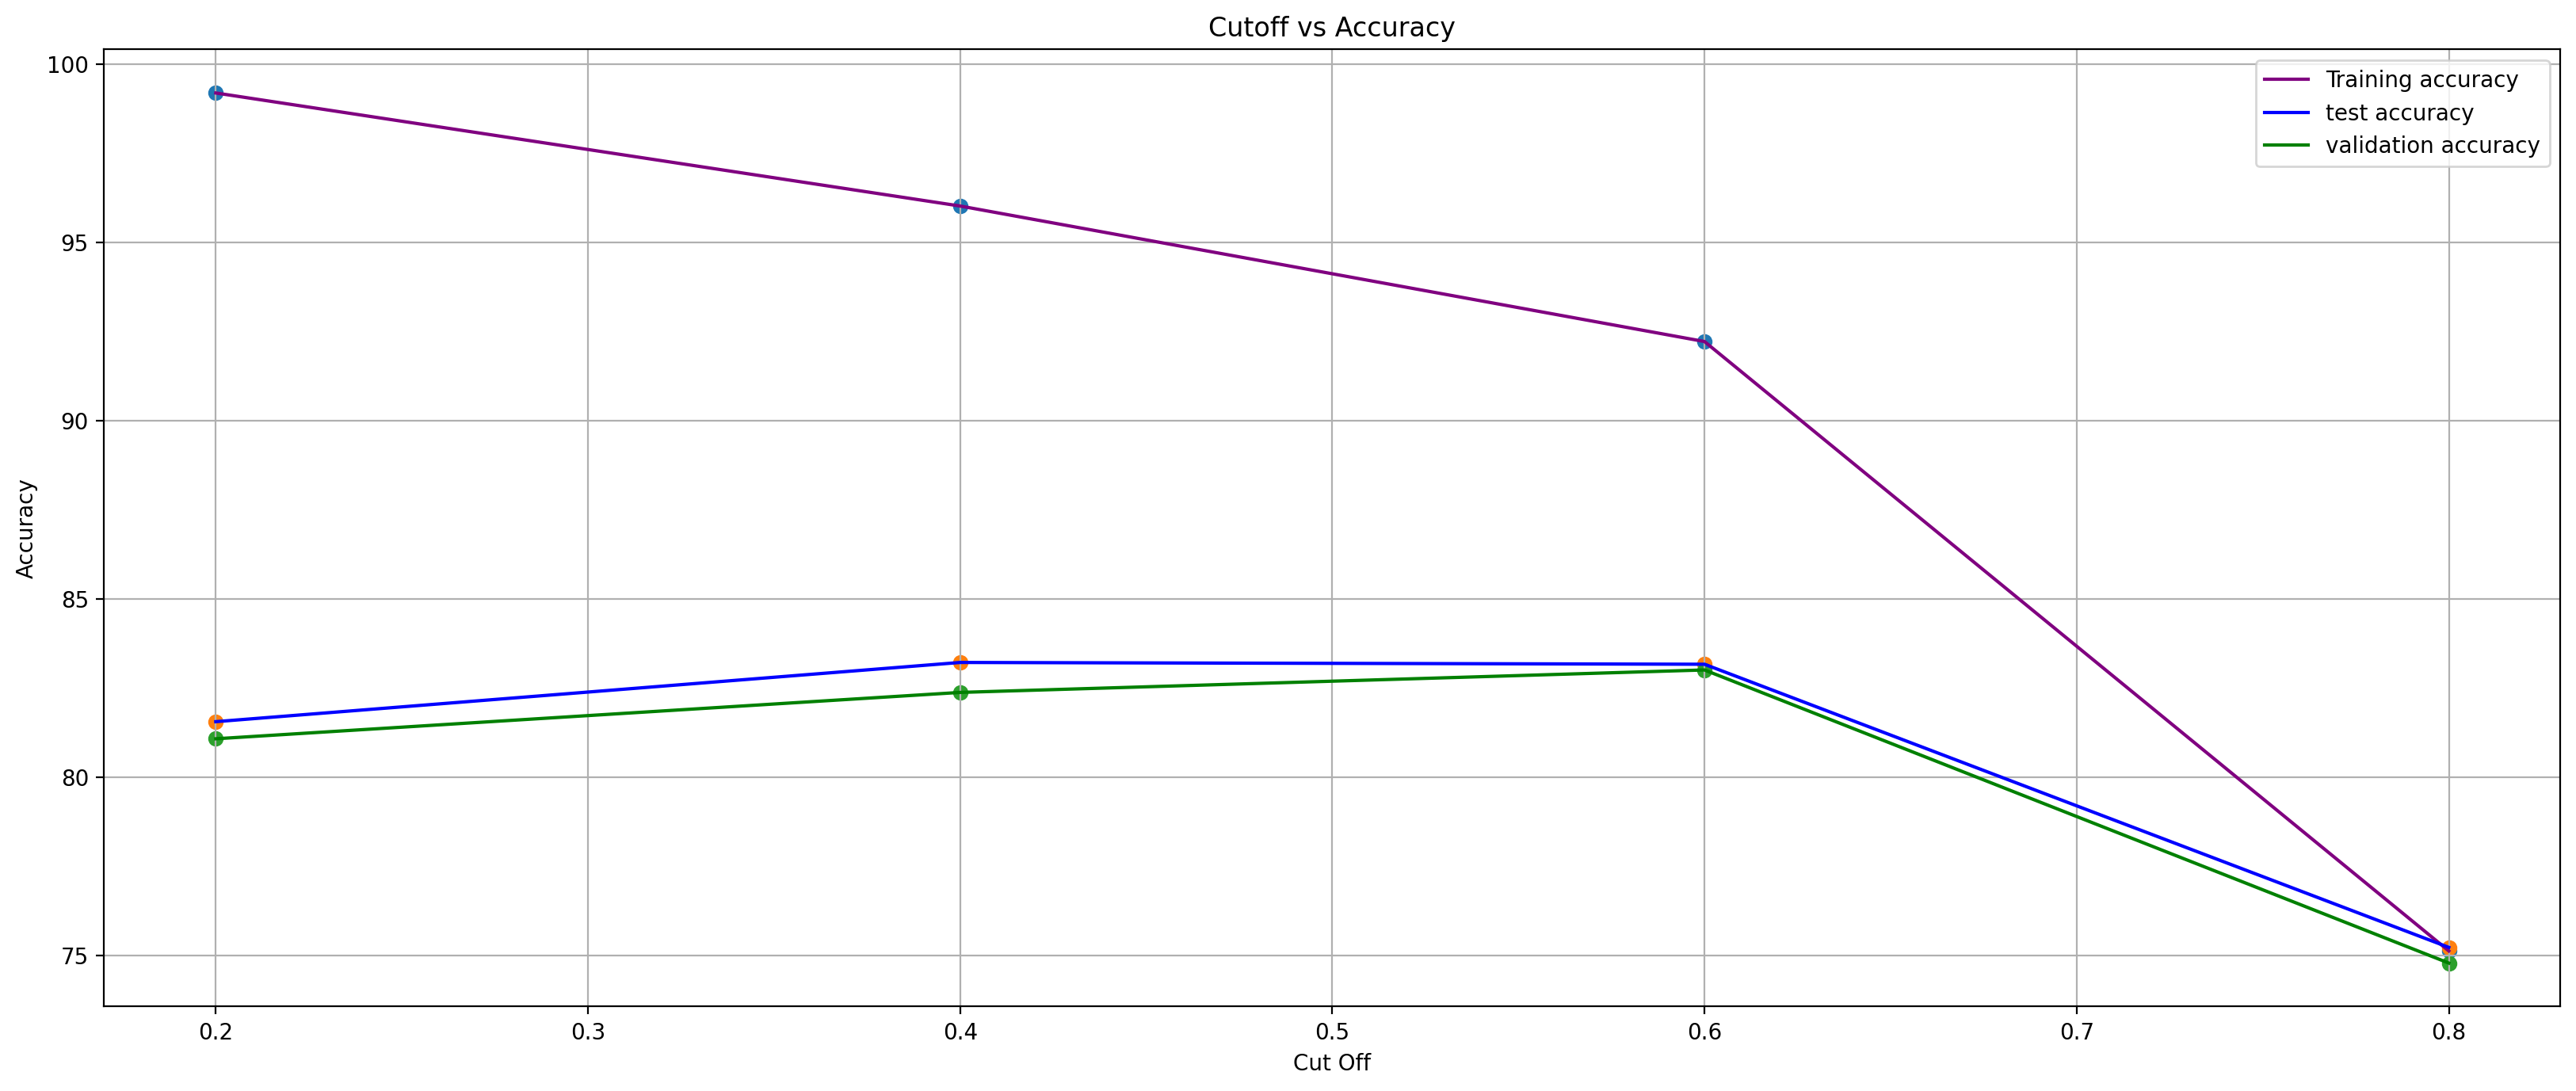

In [14]:
trainac=[float(i) for i in trainac]
testac=[float(i) for i in testac]
valac=[float(i) for i in valac]

import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(20, 8), dpi=200)
plt.grid()
#plt.subplots(1, figsize=(7,7))
plt.plot(cutoff, trainac, label="Training accuracy", color="purple")
plt.plot(cutoff, testac, label="test accuracy", color="blue")
plt.plot(cutoff, valac, label="validation accuracy", color="green")
plt.scatter(cutoff, trainac)
plt.scatter(cutoff,testac)
plt.scatter(cutoff,valac)
plt.xlabel("Cut Off")
plt.ylabel("Accuracy")
plt.title("Cutoff vs Accuracy")
#plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

<h1>training ,validation and test error for different cut off values</h1>

In [15]:
all_error = [[cutoff[0],train_error[0]*100,tester[0]*100,valer[0]*100],[cutoff[1],train_error[1]*100,tester[1]*100,valer[1]*100],[cutoff[2],train_error[2]*100,tester[2]*100,valer[2]*100],[cutoff[3],train_error[3]*100,tester[3]*100,valer[3]*100] ]

error_summary = pd.DataFrame(data = all_error, columns=['Cut off','Training error','test error','validation error'])
error_summary 

,Cut off,Training error,test error,validation error
0,0.2,0.808790,18.440755,18.921668
1,0.4,3.982909,16.780599,17.619532
2,0.6,7.777608,16.829427,16.988810
3,0.8,24.869017,24.772135,25.208545


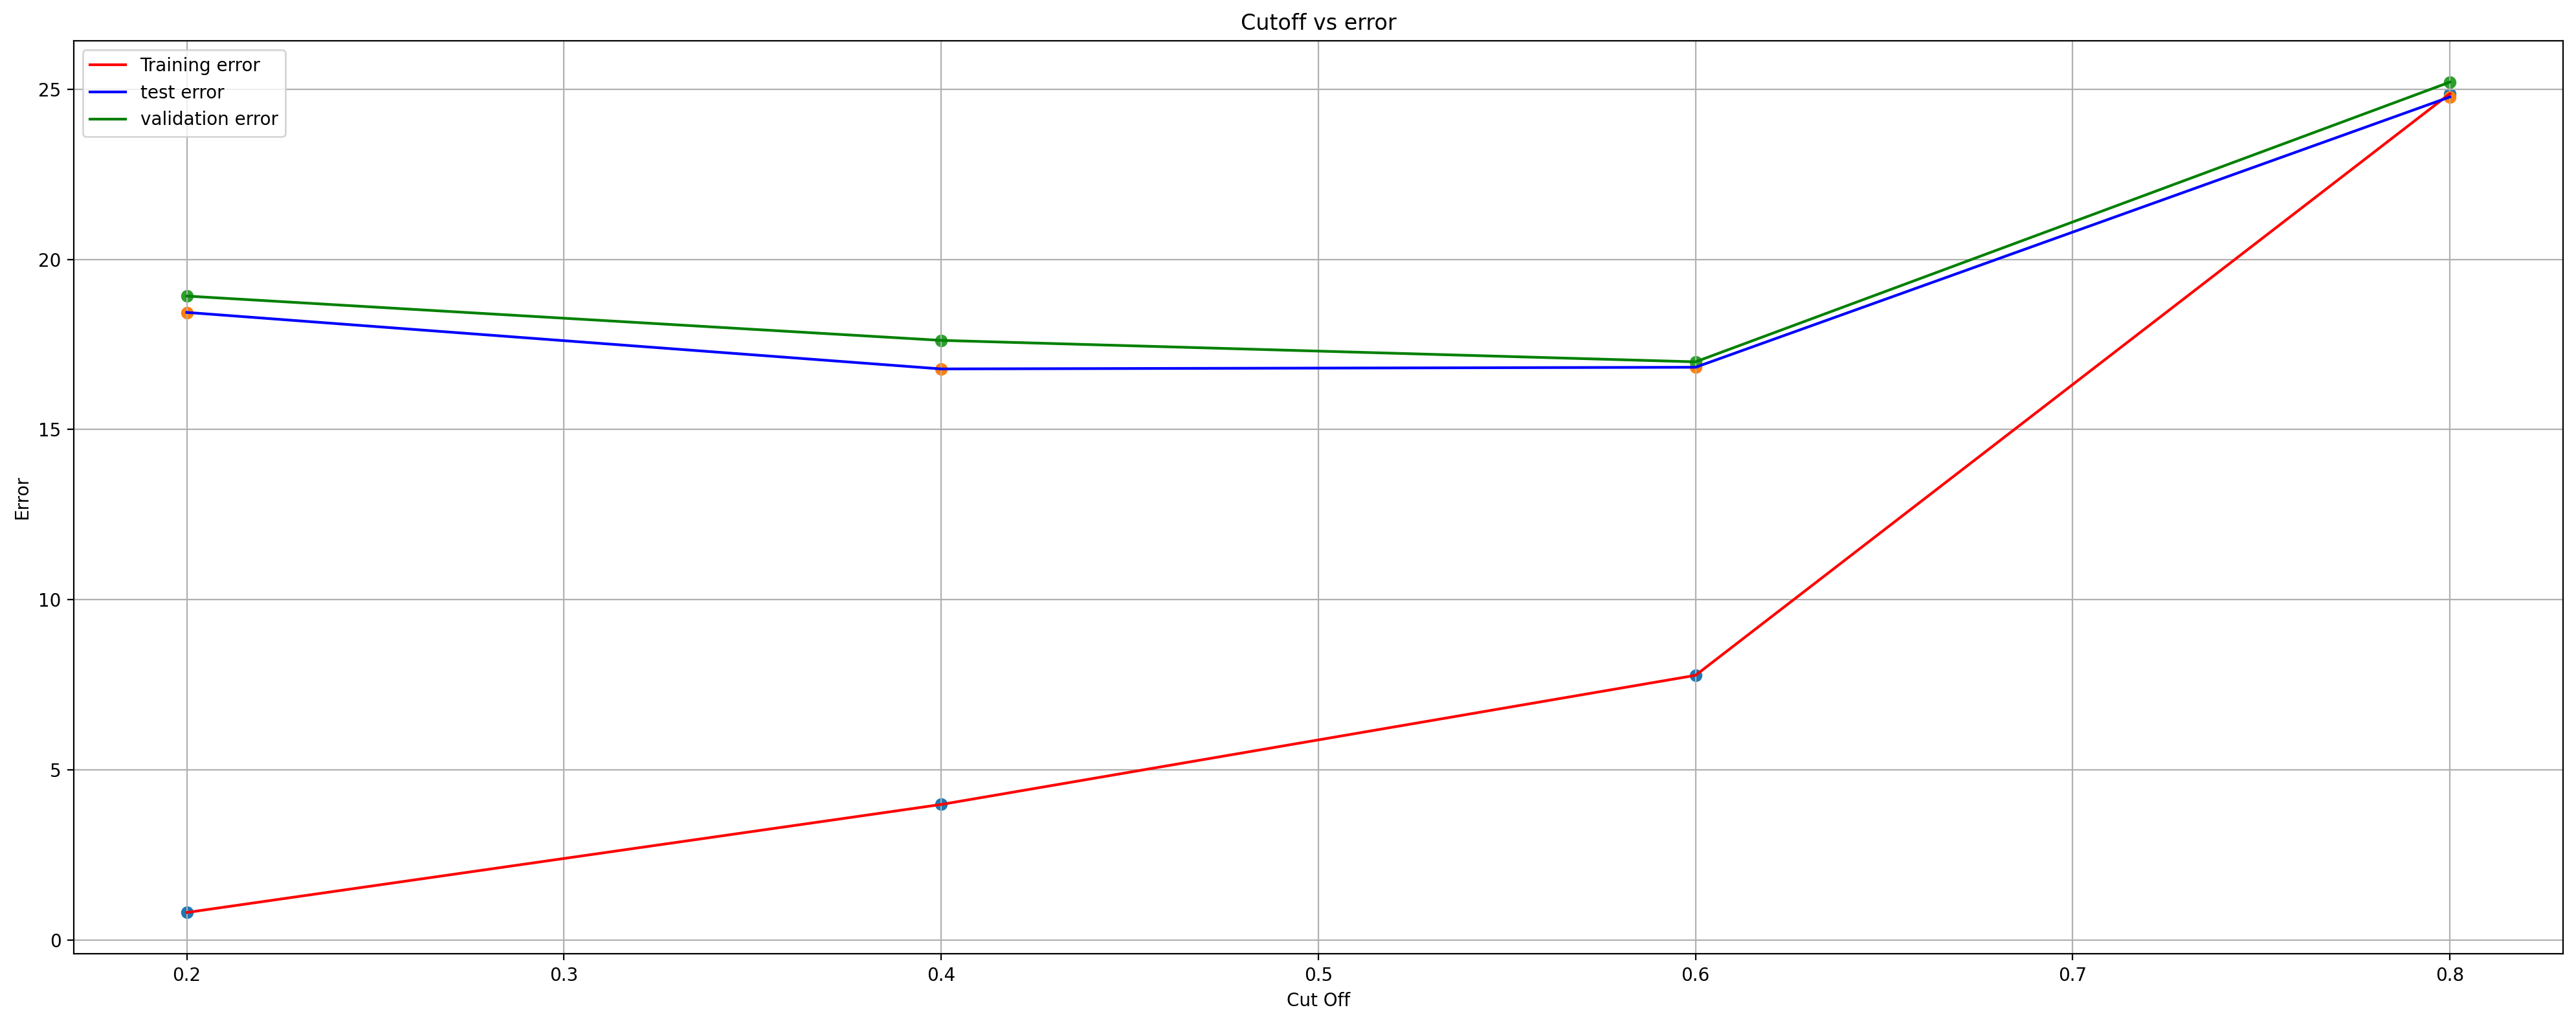

In [16]:
train_error1=[float(i*100) for i in train_error]
tester1=[float(i*100) for i in tester]
valer1=[float(i*100) for i in valer]
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(20, 8), dpi=200)
plt.grid()
#plt.subplots(1, figsize=(7,7))
plt.plot(cutoff, train_error1, label="Training error", color="red")
plt.plot(cutoff, tester1, label="test error", color="blue")
plt.plot(cutoff, valer1, label="validation error", color="green")
plt.scatter(cutoff, train_error1)
plt.scatter(cutoff,tester1)
plt.scatter(cutoff,valer1)
plt.xlabel("Cut Off")
plt.ylabel("Error")
plt.title("Cutoff vs error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

<h3> decision tree performs well when cut off value is low.For cut off value 0.8 ,decision tree performs the worst.</h3>